In [18]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

In [4]:
# Load dataset
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# Use XGBoost for RFE to stay consistent
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# RFE
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


✅ Top 10 Selected Features by RFE:
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 9
 - 10
 - 13
 - 14

❌ Features Ignored by RFE:
 - 6
 - 7
 - 8
 - 11
 - 12
 - 15


In [6]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")


2025/12/13 21:33:30 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


In [24]:
# Define models and hyperparameter grids
# models = {
#     'LinearRegression': LinearRegression(),
#     'RandomForest': RandomForestRegressor(),
#     'GradientBoosting': GradientBoostingRegressor(),
#     'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
# }

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),

    'RandomForest': RandomForestRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(random_state=42),

    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist'
    ),

    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(
        loss_function='RMSE',
        verbose=0,
        random_state=42
    )
}


# model_grids = {
#     'LinearRegression': {},
#     'RandomForest': {
#         'n_estimators': [100, 150],
#         'max_depth': [None, 10, 20]
#     },
#     'GradientBoosting': {
#         'n_estimators': [100, 500],
#         'learning_rate': [0.5, 0.05],
#         'max_depth': [3, 10]
#     },
#     'XGBoost': {
#         'n_estimators': [100, 500],
#         'learning_rate': [0.5, 0.05],
#         'max_depth': [3, 10]
#     }
# }

model_grids = {
    'LinearRegression': {},

    'Ridge': {
        'alpha': [0.1, 1.0, 10.0, 50.0]
    },

    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0]
    },

    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8]
    },

        'RandomForest': {
        'n_estimators': [200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },

    'ExtraTrees': {
        'n_estimators': [200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },

    'GradientBoosting': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },

        'XGBoost': {
        'n_estimators': [300, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },

    'LightGBM': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05],
        'num_leaves': [10, 30],
        'max_depth': [-1, 10],
        'subsample': [0.8, 1.0]
    },

    'CatBoost': {
        'iterations': [300, 600],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [3, 5]
    }
}



In [26]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://localhost:5555


In [27]:
results = {}

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


INFO:root:Training LinearRegression...
e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:00:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training Ridge...


LinearRegression R2: 0.9762, RMSE: 33266.50


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:01:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training Lasso...


Ridge R2: 0.9707, RMSE: 36932.93


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e+09, tolerance: 4.598e+08
  model = cd_fast.enet_coordinate_descent(
e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:01:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Lasso R2: 0.9762, RMSE: 33306.52


INFO:root:Training ElasticNet...
e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:01:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training RandomForest...


ElasticNet R2: 0.9702, RMSE: 37226.98


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:01:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training ExtraTrees...


RandomForest R2: 0.9872, RMSE: 24421.87


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:01:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training GradientBoosting...


ExtraTrees R2: 0.9928, RMSE: 18257.31


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:02:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training XGBoost...


GradientBoosting R2: 0.9985, RMSE: 8342.18


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:02:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training LightGBM...


XGBoost R2: 0.9914, RMSE: 19981.14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 7
[LightGBM] [Info] Start training from score 554409.836066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:02:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training CatBoost...


LightGBM R2: 0.8359, RMSE: 87416.21


e:\GenAI_Master\MLOps\IT5414-house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/12/13 22:02:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


CatBoost R2: 0.9933, RMSE: 17692.20


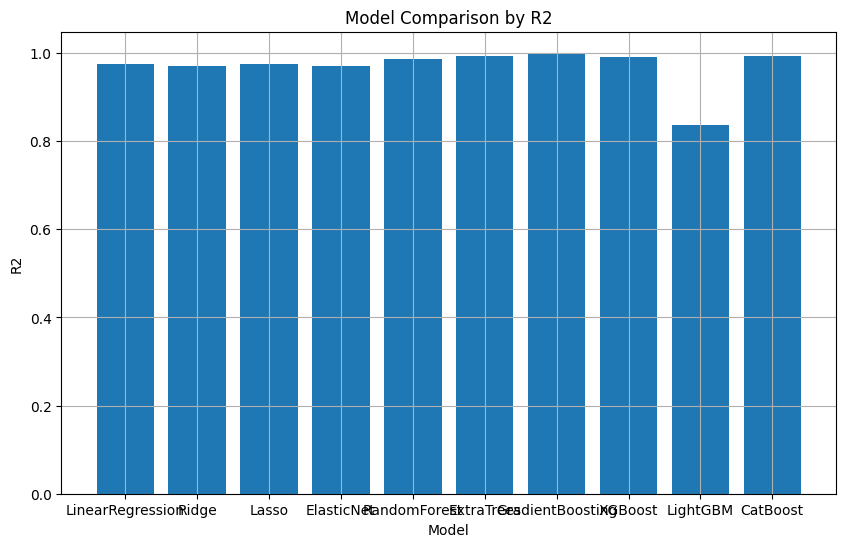

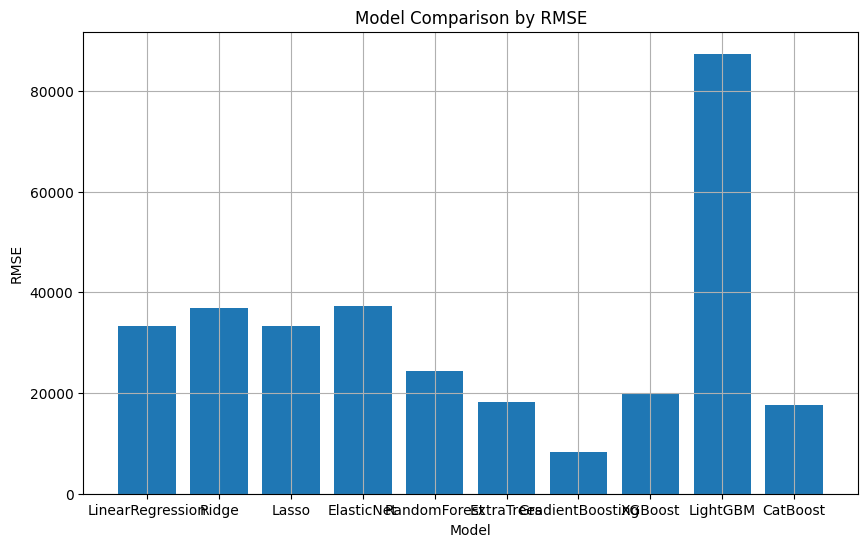

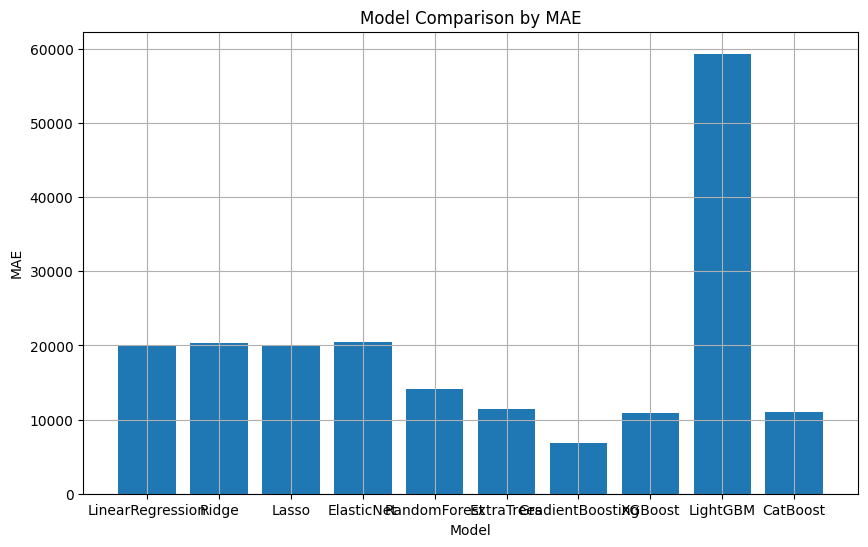

In [30]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [31]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")


🏆 Best Model: GradientBoosting
   R² Score: 0.9985
   MAE: 6879.37
   RMSE: 8342.18
Saved model config to ../configs/model_config.yaml
